In [16]:
!pip install pandas numpy msgpack matplotlib

12029.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [38]:
import pandas as pd
import os
import json


recording_location = "/Users/nirbhaysinghnarang/recordings/2024_09_18/002"
pupil_data = os.path.join(recording_location, 'pupil.pldata')
metadata_path = os.path.join(recording_location, "info.player.json")

with open(metadata_path, 'r') as file:
    metadata = json.load(file)

SYSTEM_START_TIME = metadata["start_time_system_s"]
PUPIL_LABS_START_TIME = metadata["start_time_synced_s"]
OFFSET = SYSTEM_START_TIME - PUPIL_LABS_START_TIME

In [39]:

import collections
import logging
import os
import pickle
import shutil
import traceback as tb
from glob import iglob
import msgpack
import numpy as np

class _Empty(object):
    def purge_cache(self):
        pass

logger = logging.getLogger(__name__)
UnpicklingError = pickle.UnpicklingError

PLData = collections.namedtuple('PLData', ['data', 'timestamps', 'topics'])

class _FrozenDict(dict):
    def __setitem__(self, key, value):
        raise NotImplementedError('Invalid operation')

    def clear(self):
        raise NotImplementedError()

    def update(self, *args, **kwargs):
        raise NotImplementedError()

class Serialized_Dict(object):
    __slots__ = ['_ser_data', '_data']
    cache_len = 100
    _cache_ref = [_Empty()] * cache_len
    MSGPACK_EXT_CODE = 13

    def __init__(self, python_dict=None, msgpack_bytes=None):
        if type(python_dict) is dict:
            self._ser_data = msgpack.packb(python_dict, use_bin_type=True,
                                           default=self.packing_hook)
        elif type(msgpack_bytes) is bytes:
            self._ser_data = msgpack_bytes
        else:
            raise ValueError("Neither mapping nor payload is supplied or wrong format.")
        self._data = None

    def _deser(self):
        if not self._data:
            self._data = msgpack.unpackb(self._ser_data, raw=False, use_list=False,
                                         object_hook=self.unpacking_object_hook,
                                         ext_hook=self.unpacking_ext_hook)
            self._cache_ref.pop(0).purge_cache()
            self._cache_ref.append(self)

    @classmethod
    def unpacking_object_hook(self,obj):
        if type(obj) is dict:
            return _FrozenDict(obj)

    @classmethod
    def packing_hook(self, obj):
        if isinstance(obj, self):
            return msgpack.ExtType(self.MSGPACK_EXT_CODE, obj.serialized)
        raise TypeError("can't serialize {}({})".format(type(obj), repr(obj)))

    @classmethod
    def unpacking_ext_hook(self, code, data):
        if code == self.MSGPACK_EXT_CODE:
            return self(msgpack_bytes=data)
        return msgpack.ExtType(code, data)

    def purge_cache(self):
        self._data = None

    @property
    def serialized(self):
        return self._ser_data

    def __setitem__(self, key, item):
        raise NotImplementedError()

    def __getitem__(self, key):
        self._deser()
        return self._data[key]

    def __repr__(self):
        self._deser()
        return 'Serialized_Dict({})'.format(repr(self._data))

    @property
    def len(self):
        '''Replacement implementation for __len__

        If __len__ is defined numpy will recognize this as nested structure and
        start deserializing everything instead of using this object as it is.
        '''
        self._deser()
        return len(self._data)

    def __delitem__(self, key):
        raise NotImplementedError()

    def get(self,key,default):
        try:
            return self[key]
        except KeyError:
            return default

    def clear(self):
        raise NotImplementedError()

    def copy(self):
        self._deser()
        return self._data.copy()

    def has_key(self, k):
        self._deser()
        return k in self._data

    def update(self, *args, **kwargs):
        raise NotImplementedError()

    def keys(self):
        self._deser()
        return self._data.keys()

    def values(self):
        self._deser()
        return self._data.values()

    def items(self):
        self._deser()
        return self._data.items()

    def pop(self, *args):
        raise NotImplementedError()

    def __cmp__(self, dict_):
        self._deser()
        return self._data.__cmp__(dict_)

    def __contains__(self, item):
        self._deser()
        return item in self._data

    def __iter__(self):
        self._deser()
        return iter(self._data)

In [40]:

import collections
import msgpack
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def load_pldata(file_path):

    topics = collections.deque()
    with open(file_path, "rb") as f:
        unpacker = msgpack.Unpacker(f, raw=False, use_list=False)
        for topic, payload in unpacker:
            unpacked = Serialized_Dict(msgpack_bytes=payload)
            topics.append(unpacked)
            
            
    return topics


    
topics = load_pldata(pupil_data)
print(topics)




Timestamp difference: 0.0020650000078603625
Sampling frequency: 484.2614993673264 Hz
  Difficulty  Start Time (Unix)  End Time (Unix)  Duration (seconds)
0       Easy       1.726714e+09     1.726714e+09               36.35
1       Hard       1.726714e+09     1.726714e+09               43.11
2       Hard       1.726714e+09     1.726714e+09               40.30
3       Easy       1.726714e+09     1.726714e+09               32.25
4       Easy       1.726714e+09     1.726714e+09               32.46
5       Hard       1.726714e+09     1.726714e+09               43.56


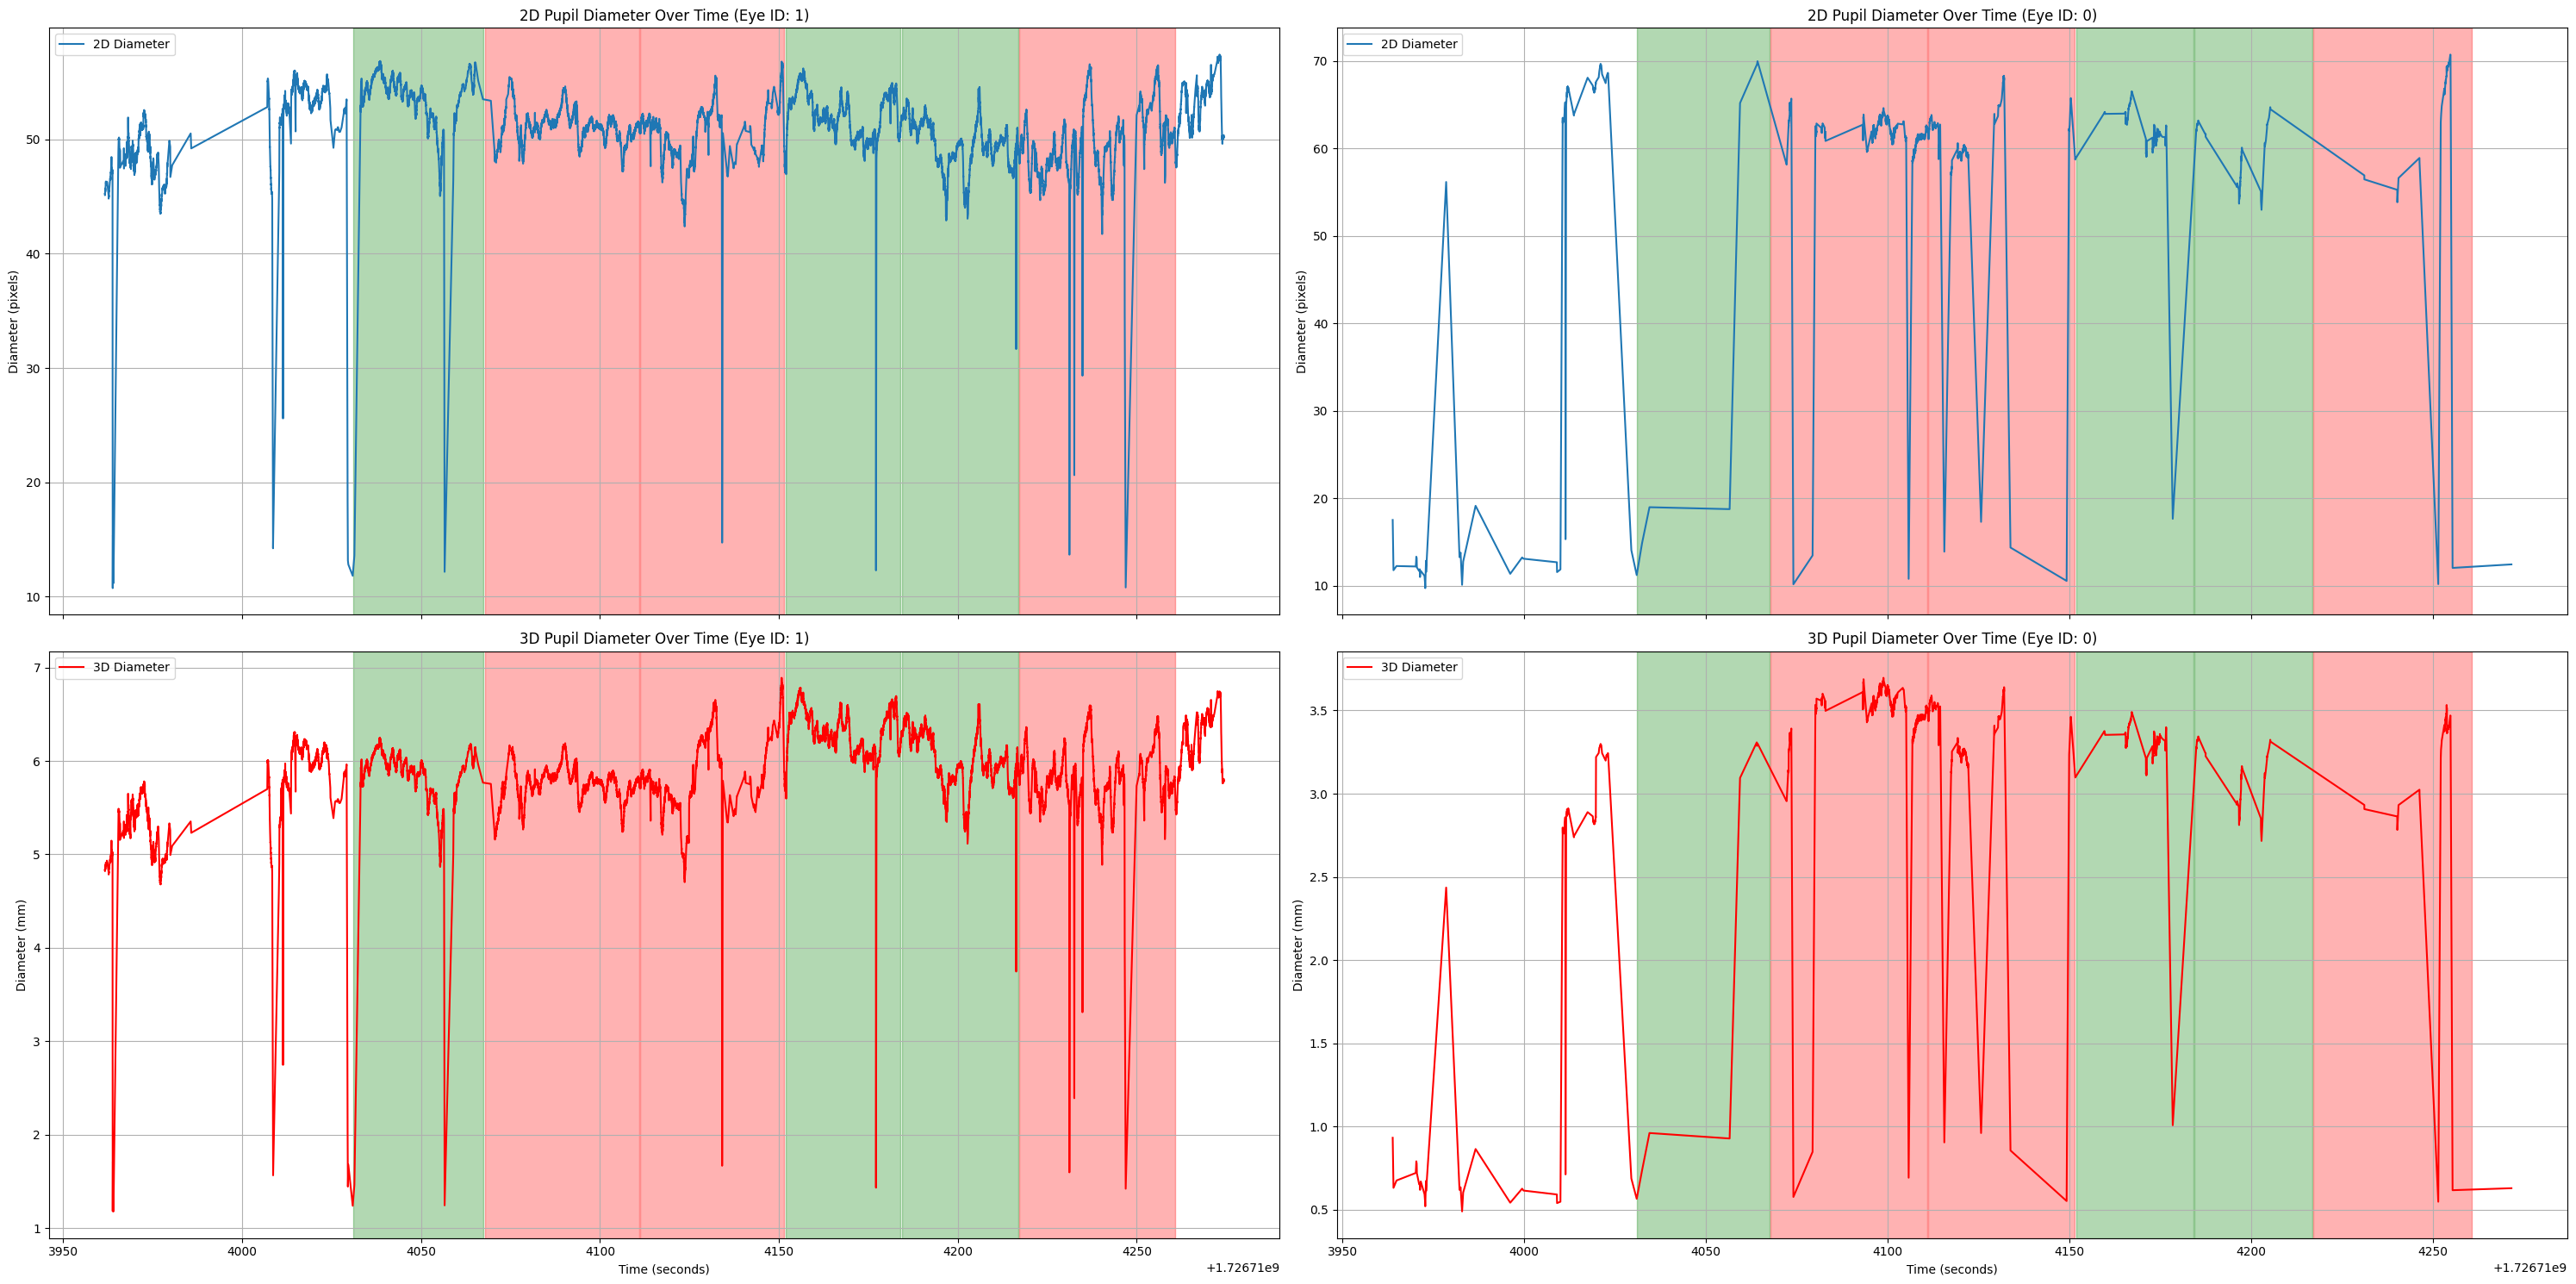